# 1. SalePriceとの相関をヒートマップで可視化する


SalePriceとの相関:
 SalePrice       1.000000
OverallQual     0.816856
GrLivArea       0.729311
ExterQual       0.699291
KitchenQual     0.679995
GarageCars      0.675896
BsmtQual        0.671338
GarageArea      0.660029
TotalBsmtSF     0.645251
1stFlrSF        0.621873
FullBath        0.583994
YearBuilt       0.570327
YearRemodAdd    0.552061
TotRmsAbvGrd    0.539339
GarageYrBlt     0.499210
HeatingQC       0.460160
LotArea         0.435876
LotFrontage     0.375850
Name: SalePrice, dtype: float64


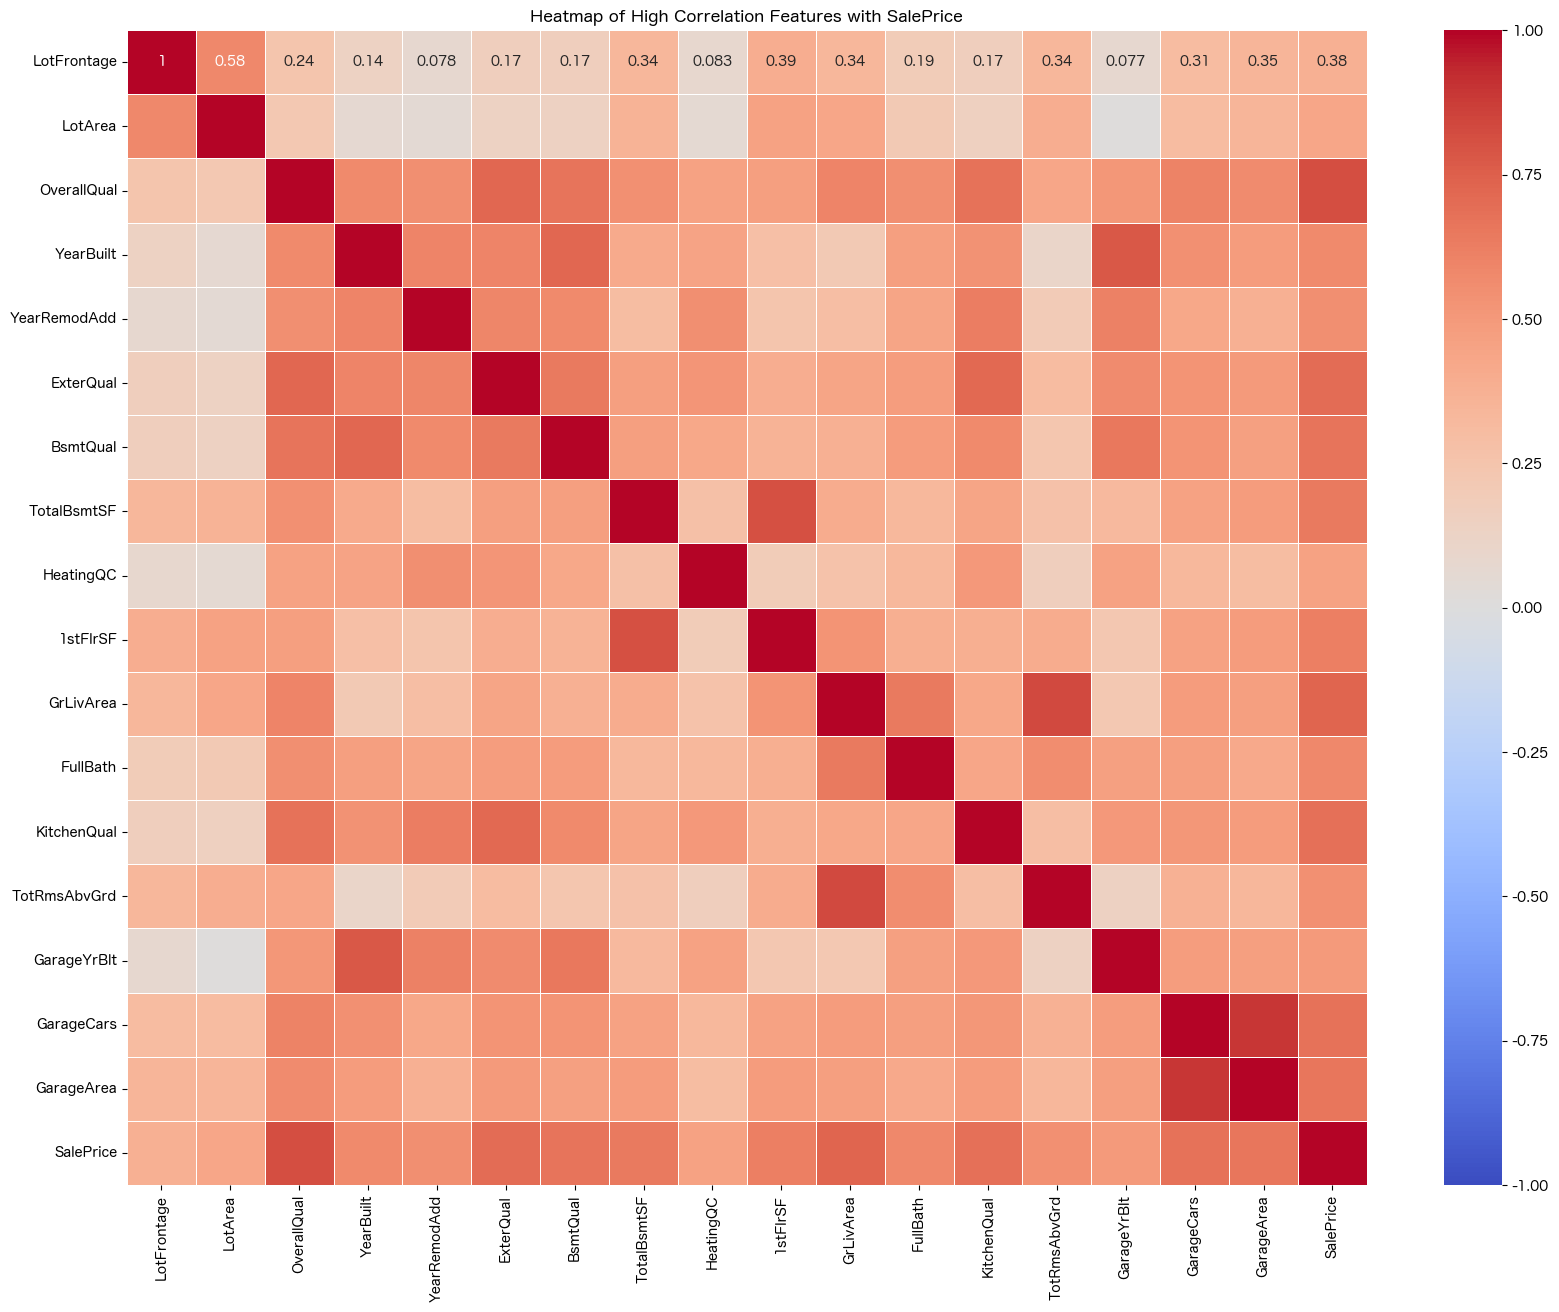

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/house_price/train/train19.csv'
data_cleaned = pd.read_csv(data_path)

# 数値型の特徴量のみを対象とする
numeric_features = data_cleaned.select_dtypes(include=[np.number])

# SalePriceとの相関を計算
correlation_matrix = numeric_features.corr()

# 相関係数が0.3以上の特徴量を選択
high_correlation_features = correlation_matrix["SalePrice"][correlation_matrix["SalePrice"].abs() >= 0.3].index

# 選択された特徴量で相関行列を再作成
high_correlation_matrix = numeric_features[high_correlation_features].corr()

# SalePriceとの相関を取り出し、降順に並べ替える
saleprice_correlation = high_correlation_matrix["SalePrice"].sort_values(ascending=False)
print("\nSalePriceとの相関:\n", saleprice_correlation)

# ヒートマップをプロット
plt.figure(figsize=(20, 15))
sns.heatmap(high_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Heatmap of High Correlation Features with SalePrice')
plt.show()


# 2.新しい特徴量を作成する

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/house_price/train/train19.csv'
train_df = pd.read_csv(data_path)

# 数値型データの処理
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
train_df[numeric_cols] = train_df[numeric_cols].replace([np.inf, -np.inf], np.nan)  # 無限大の値をNaNに置き換え
train_df[numeric_cols] = train_df[numeric_cols].fillna(0)  # NaNを0で置き換える

# 新しい特徴量の作成
train_df['TotalArea'] = train_df['GrLivArea'] + train_df['TotalBsmtSF'] + train_df['GarageArea']
train_df['YearsSinceRemodel'] = train_df['YrSold'] - train_df['YearRemodAdd'] 
train_df['HouseAge'] = train_df['YrSold'] - train_df['YearBuilt'] 
train_df['AreaPerYearRatio'] = train_df['GrLivArea'] / np.maximum(train_df['HouseAge'], 1e-5)
train_df['LotAreaSquared'] = train_df['LotArea'] ** 2
train_df['AreaRatio'] = train_df['GrLivArea'] / np.maximum(train_df['LotArea'], 1e-5)
train_df['InverseYearsSinceRemodel'] = 1 / np.maximum(train_df['YearsSinceRemodel'], 1e-5)
train_df['Age'] = train_df['YrSold'] - train_df[['YearBuilt', 'YearRemodAdd']].max(axis=1)
train_df['GarageAreaPerCar'] = train_df['GarageArea'] / np.maximum(train_df['GarageCars'], 1e-5)
train_df['GarageScore'] = train_df['GarageCars'] * train_df['GarageArea']
train_df['LotShapeQuality'] = train_df['LotArea'] * train_df['LotFrontage']
train_df['HasBsmt'] = (train_df['TotalBsmtSF'] > 0).astype(int)
train_df['TotalRooms'] = train_df['TotRmsAbvGrd'] + (train_df['BsmtQual'] > 0).astype(int) * 2  # 地下室を部屋数に加算
train_df['QualityScore'] = train_df['OverallQual'] + train_df['ExterQual'] + train_df['KitchenQual'] + train_df['BsmtQual'] + train_df['HeatingQC']

# BsmtQualとBsmtCondはすでに数値に変換済み
# BsmtQualとBsmtCondを使ってBsmtQualityIndexを作成
train_df['BsmtQualityIndex'] = train_df['BsmtQual'] * train_df['BsmtCond']

# 地下室の露出マッピング
exposure_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
train_df['BsmtExposure_Score'] = train_df['BsmtExposure'].map(exposure_mapping)

# 地下室完成タイプ1と2のマッピング
fin_type_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}
train_df['BsmtFinType1_Score'] = train_df['BsmtFinType1'].map(fin_type_mapping)
train_df['BsmtFinType2_Score'] = train_df['BsmtFinType2'].map(fin_type_mapping)

# 地下室の総仕上げレベル
train_df['TotalBsmtFin'] = train_df['BsmtFinType1_Score'] + train_df['BsmtFinType2_Score']

# 新しい特徴量を作成：質と条件の総合評価
train_df['QualityCondition'] = train_df['OverallQual'] * train_df['OverallCond']

# 質と条件の平均値を別の特徴量として加える
train_df['AvgQualityCondition'] = (train_df['OverallQual'] + train_df['OverallCond']) / 2

# ディレクトリが存在するか確認し、存在しない場合は作成
save_dir = '/Users/hayakawakazue/Downloads/house_price/train'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存
data_cleaned_path = os.path.join(save_dir, 'train_new_feature_engineered.csv')
train_df.to_csv(data_cleaned_path, index=False)

print(f"新しい特徴量を追加してデータを保存しました: {data_cleaned_path}")


新しい特徴量を追加してデータを保存しました: /Users/hayakawakazue/Downloads/house_price/train/train_new_feature_engineered.csv



SalePriceとの相関:
 SalePrice              1.000000
TotalArea              0.852962
QualityScore           0.822604
OverallQual            0.816856
GrLivArea              0.729311
GarageScore            0.711305
ExterQual              0.699291
KitchenQual            0.679995
GarageCars             0.675896
BsmtQual               0.671338
GarageArea             0.660029
TotalBsmtSF            0.645251
BsmtQualityIndex       0.631471
1stFlrSF               0.621873
AvgQualityCondition    0.617712
QualityCondition       0.586845
FullBath               0.583994
YearBuilt              0.570327
YearRemodAdd           0.552061
TotalRooms             0.539339
TotRmsAbvGrd           0.539339
GarageYrBlt            0.499210
LotShapeQuality        0.469907
HeatingQC              0.460160
LotArea                0.435876
LotAreaSquared         0.425194
YearsSinceRemodel     -0.554206
Age                   -0.554206
HouseAge              -0.570820
Name: SalePrice, dtype: float64


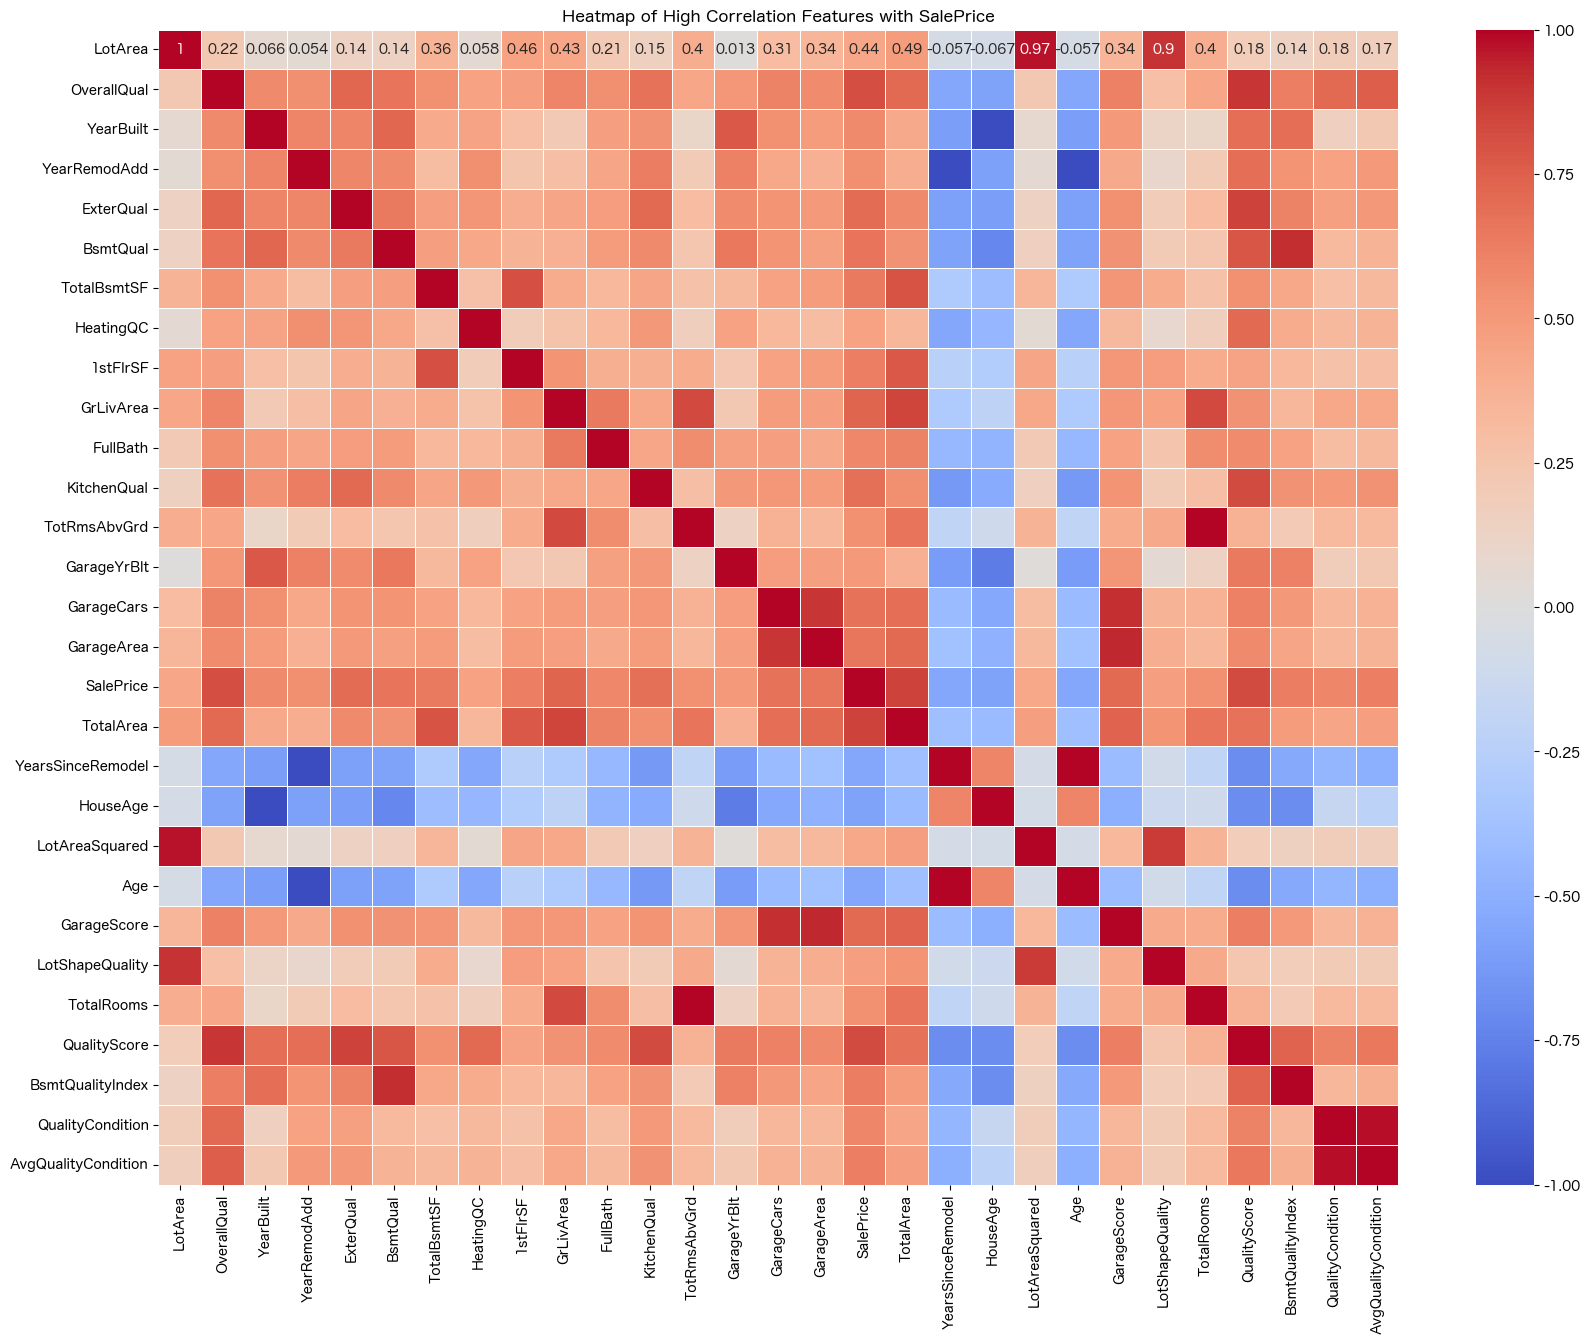

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 日本語フォントの設定
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro']  # Mac用
plt.rcParams['axes.unicode_minus'] = False

# データの読み込み
data_path = '/Users/hayakawakazue/Downloads/house_price/train/train_new_feature_engineered.csv'
data_cleaned = pd.read_csv(data_path)

# 数値型の特徴量のみを対象とする
numeric_features = data_cleaned.select_dtypes(include=[np.number])

# SalePriceとの相関を計算
correlation_matrix = numeric_features.corr()

# 相関係数が0.4以上の特徴量を選択
high_correlation_features = correlation_matrix["SalePrice"][correlation_matrix["SalePrice"].abs() >= 0.4].index

# 選択された特徴量で相関行列を再作成
high_correlation_matrix = numeric_features[high_correlation_features].corr()

# SalePriceとの相関を取り出し、降順に並べ替える
saleprice_correlation = high_correlation_matrix["SalePrice"].sort_values(ascending=False)
print("\nSalePriceとの相関:\n", saleprice_correlation)

# ヒートマップをプロット
plt.figure(figsize=(20, 15))
sns.heatmap(high_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Heatmap of High Correlation Features with SalePrice')
plt.show()

